In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [3]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}
NUM_LABELS = 3


In [4]:
from google.colab import files
uploaded = files.upload()
csv_name = next(iter(uploaded))
df = pd.read_csv(csv_name)

print(df.columns)
df.head()


Saving SEntFiN.csv to SEntFiN.csv
Index(['S No.', 'Title', 'Decisions', 'Words'], dtype='object')


,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [5]:
import json
import pandas as pd

def parse_decisions(x):
    if pd.isna(x):
        return {}
    s = str(x).strip()
    try:
        return json.loads(s)
    except Exception:
        try:
            return json.loads(s.replace("'", '"'))
        except Exception:
            return {}

def norm_sent(lbl):
    lbl = str(lbl).strip().lower()
    if lbl in ["positive","pos","bullish","up","buy"]:
        return "positive"
    if lbl in ["negative","neg","bearish","down","sell"]:
        return "negative"
    return "neutral"

label2id = {"negative": 0, "neutral": 1, "positive": 2}

rows = []
for _, r in df.iterrows():
    title = str(r.get("Title","")).strip()
    dec = parse_decisions(r.get("Decisions", None))
    if not title or not dec:
        continue
    for ent, sent in dec.items():
        rows.append({
            "text": title,
            "label": label2id[norm_sent(sent)]
        })

df_proc = pd.DataFrame(rows)
print("Processed df:", df_proc.shape)
print(df_proc.columns.tolist())
df_proc.head()


Processed df: (14409, 2)
['text', 'label']


,text,label
0,SpiceJet to issue 6.4 crore warrants to promoters,1
1,MMTC Q2 net loss at Rs 10.4 crore,1
2,"Mid-cap funds can deliver more, stay put: Experts",2
3,Mid caps now turn into market darlings,2
4,"Market seeing patience, if not conviction: Pra...",1


In [6]:
X = df_proc["text"].tolist()
y = df_proc["label"].tolist()

from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print(len(X_train), len(X_val), len(X_test))

print(len(X_val), len(y_val), len(X_test), len(y_test))
print("Example:", X_test[0], y_test[0])


11527 1441 1441
1441 1441 1441 1441
Example: JBM Auto Q1 net profit soars 60 per cent 2


In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

FINBERT_PATH = "finbert_sentiment_model"
DEBERTA_PATH = "deberta_finance_sentiment_model"

FINBERT_FALLBACK = "ProsusAI/finbert"
DEBERTA_FALLBACK = "mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"

finbert_src = FINBERT_PATH if os.path.isdir(FINBERT_PATH) else FINBERT_FALLBACK
deberta_src = DEBERTA_PATH if os.path.isdir(DEBERTA_PATH) else DEBERTA_FALLBACK

print("FinBERT source:", finbert_src)
print("DeBERTa source:", deberta_src)

fin_tok = AutoTokenizer.from_pretrained(finbert_src)
deb_tok = AutoTokenizer.from_pretrained(deberta_src)

fin_model = AutoModelForSequenceClassification.from_pretrained(finbert_src, num_labels=NUM_LABELS).to(DEVICE)
deb_model = AutoModelForSequenceClassification.from_pretrained(deberta_src, num_labels=NUM_LABELS).to(DEVICE)

fin_model.eval()
deb_model.eval()


DEVICE: cuda
FinBERT source: ProsusAI/finbert
DeBERTa source: mrm8488/deberta-v3-ft-financial-news-sentiment-analysis


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/568M [00:00<?, ?B/s]

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [8]:
@torch.no_grad()
def predict_proba(texts, tokenizer, model, max_length=128, batch_size=32):
    probs_all = []
    for i in range(0, len(texts), batch_size):
        batch_text = texts[i:i+batch_size]
        enc = tokenizer(
            batch_text,
            truncation=True,
            max_length=max_length,
            padding=True,
            return_tensors="pt"
        ).to(DEVICE)

        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        probs_all.append(probs)

    return np.vstack(probs_all)


In [9]:
def ensemble_predict(texts, w_fin=0.5, w_deb=0.5, max_length=128, batch_size=32):
    p_fin = predict_proba(texts, fin_tok, fin_model, max_length=max_length, batch_size=batch_size)
    p_deb = predict_proba(texts, deb_tok, deb_model, max_length=max_length, batch_size=batch_size)

    p_ens = w_fin * p_fin + w_deb * p_deb
    pred = np.argmax(p_ens, axis=-1)
    return p_ens, pred


In [10]:
def eval_split(name, X, y, w_fin=0.5, w_deb=0.5):
    p, pred = ensemble_predict(X, w_fin=w_fin, w_deb=w_deb, max_length=128, batch_size=32)
    acc = accuracy_score(y, pred)
    mf1 = f1_score(y, pred, average="macro")
    return acc, mf1, pred

# Equal-weight ensemble
val_acc, val_f1, val_pred = eval_split("val", X_val, y_val, 0.5, 0.5)
test_acc, test_f1, test_pred = eval_split("test", X_test, y_test, 0.5, 0.5)

print("ENSEMBLE VAL accuracy:", val_acc, "macro_f1:", val_f1)
print("ENSEMBLE TEST accuracy:", test_acc, "macro_f1:", test_f1)

results = pd.DataFrame([
    {"model":"finbert+deberta_ensemble", "split":"val",  "accuracy": float(val_acc),  "macro_f1": float(val_f1)},
    {"model":"finbert+deberta_ensemble", "split":"test", "accuracy": float(test_acc), "macro_f1": float(test_f1)},
])
results.to_csv("ensemble_finbert_deberta_results.csv", index=False)
results


ENSEMBLE VAL accuracy: 0.6703678001387925 macro_f1: 0.6734571585420235
ENSEMBLE TEST accuracy: 0.6717557251908397 macro_f1: 0.6765462597105958


,model,split,accuracy,macro_f1
0,finbert+deberta_ensemble,val,0.670368,0.673457
1,finbert+deberta_ensemble,test,0.671756,0.676546


In [11]:
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:\n",
      classification_report(y_test, test_pred, target_names=[id2label[i] for i in range(3)]))


Confusion matrix:
 [[264 105  13]
 [ 62 361 129]
 [ 40 124 343]]

Classification report:
               precision    recall  f1-score   support

    negative       0.72      0.69      0.71       382
     neutral       0.61      0.65      0.63       552
    positive       0.71      0.68      0.69       507

    accuracy                           0.67      1441
   macro avg       0.68      0.67      0.68      1441
weighted avg       0.67      0.67      0.67      1441



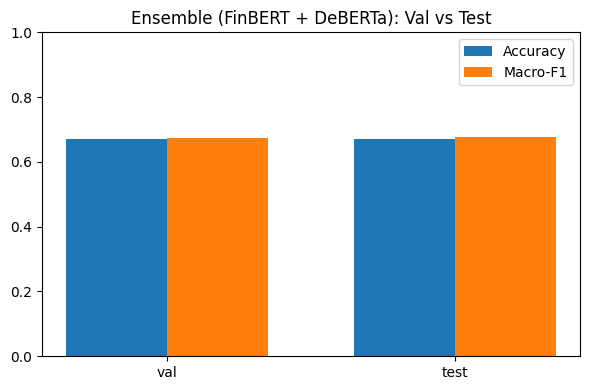

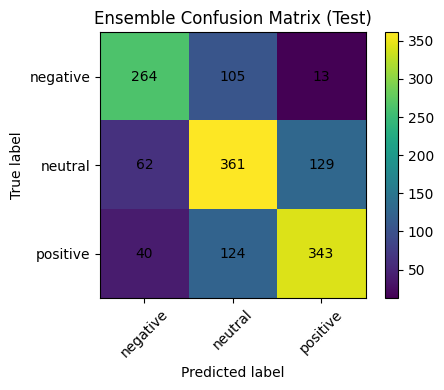

In [12]:
os.makedirs("figures", exist_ok=True)

# Bar plot: val vs test
labels = ["val", "test"]
accs = [val_acc, test_acc]
f1s  = [val_f1,  test_f1]

x = np.arange(len(labels))
w = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - w/2, accs, w, label="Accuracy")
plt.bar(x + w/2, f1s,  w, label="Macro-F1")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Ensemble (FinBERT + DeBERTa): Val vs Test")
plt.legend()
plt.tight_layout()
plt.savefig("figures/ensemble_val_test_metrics.png", dpi=200)
plt.show()

# Confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Ensemble Confusion Matrix (Test)")
plt.colorbar()
ticks = np.arange(3)
plt.xticks(ticks, [id2label[i] for i in range(3)], rotation=45)
plt.yticks(ticks, [id2label[i] for i in range(3)])
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("figures/ensemble_confusion_matrix.png", dpi=200)
plt.show()


In [13]:
best = None
for w_fin in np.linspace(0, 1, 11):
    w_deb = 1 - w_fin
    acc, mf1, _ = eval_split("val", X_val, y_val, w_fin, w_deb)
    cand = (mf1, acc, w_fin, w_deb)
    if best is None or cand > best:
        best = cand

best_mf1, best_acc, best_w_fin, best_w_deb = best
print("Best VAL macro_f1:", best_mf1, "acc:", best_acc, "weights fin/deb:", best_w_fin, best_w_deb)

test_acc_w, test_f1_w, test_pred_w = eval_split("test", X_test, y_test, best_w_fin, best_w_deb)
print("BEST-WEIGHT TEST accuracy:", test_acc_w, "macro_f1:", test_f1_w)


Best VAL macro_f1: 0.6926923026446232 acc: 0.6884108258154059 weights fin/deb: 0.2 0.8
BEST-WEIGHT TEST accuracy: 0.6960444136016655 macro_f1: 0.7021239046708573
